In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pytest
from batdetect2.compat.data import load_annotation_project
from batdetect2.compat.params import get_training_preprocessing_config
from batdetect2.train.preprocess import generate_train_example

/home/santiago/Software/bat_detectors/batdetect2/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
regression_dir = Path("../tests/data/regression/")
example_audio_dir = Path("../example_data/audio/")
example_audio_files = list(example_audio_dir.glob("*.wav"))
example_anns_dir = Path("../example_data/anns/")

audio_file = example_audio_files[0]
example_file = regression_dir / f"{audio_file.name}.npz"

dataset = np.load(example_file)

spec = dataset["spec"][0]
detection_mask = dataset["detection_mask"][0]
size_mask = dataset["size_mask"]
class_mask = dataset["class_mask"]

project = load_annotation_project(
    example_anns_dir,
    audio_dir=example_audio_dir,
)

clip_annotation = next(
    ann for ann in project.clip_annotations if ann.clip.recording.path == audio_file
)

In [4]:
clip_annotation.clip.duration

0.5

In [5]:
old_parameters = json.loads((regression_dir / "params.json").read_text())
config = get_training_preprocessing_config(old_parameters)

In [6]:
config.preprocessing.spectrogram.size

SpecSizeConfig(height=256, resize_factor=0.5, divide_factor=32)

In [7]:
new_dataset = generate_train_example(clip_annotation, config)
new_spec = new_dataset["spectrogram"].values
new_detection_mask = new_dataset["detection"].values
new_size_mask = new_dataset["size"].values
new_class_mask = new_dataset["class"].values

In [8]:
new_spec.shape

(128, 512)

In [9]:
new_dataset["class"].category

<xarray.DataArray 'category' (category: 17)> Size: 2kB
array(['Barbastellus barbastellus', 'Eptesicus serotinus', 'Myotis alcathoe',
       'Myotis bechsteinii', 'Myotis brandtii', 'Myotis daubentonii',
       'Myotis mystacinus', 'Myotis nattereri', 'Nyctalus leisleri',
       'Nyctalus noctula', 'Pipistrellus nathusii',
       'Pipistrellus pipistrellus', 'Pipistrellus pygmaeus',
       'Plecotus auritus', 'Plecotus austriacus', 'Rhinolophus ferrumequinum',
       'Rhinolophus hipposideros'], dtype='<U25')
Coordinates:
    channel   int64 8B 0
  * category  (category) <U25 2kB 'Barbastellus barbastellus' ... 'Rhinolophu...

In [10]:
assert spec.shape == new_spec.shape
assert detection_mask.shape == new_detection_mask.shape
assert size_mask.shape == new_size_mask.shape
assert class_mask.shape[1:] == new_class_mask.shape[1:]
assert class_mask.shape[0] == new_class_mask.shape[0] + 1

In [11]:
def plot_versions(
    original_version,
    new_version,
    title="",
    figsize=(20, 6),
    cmap="gray",
):
    plt.figure(figsize=figsize, facecolor="black")
    ax1 = plt.subplot(3, 1, 1)
    ax1.pcolormesh(np.flipud(original_version), cmap=cmap)
    ax1.set_title("Original", fontdict={'color': "white"})
    ax1.axis("off")
    
    ax2 = plt.subplot(3, 1, 2)
    ax2.pcolormesh(new_version, cmap=cmap)
    ax2.set_title("New", fontdict={'color': "white"})
    ax2.axis("off")
    
    max_val = max(original_version.max(), new_version.max())
    
    original_n = original_version / max_val
    new_n = new_version / max_val
    diff = np.abs(np.flipud(original_n) - new_n)
    ax3 = plt.subplot(3, 1, 3)
    ax3.pcolormesh(
        np.stack([np.flipud(original_n), new_n, np.flipud(original_n), diff], axis=-1,)
    )
    ax3.set_title("Difference", fontdict={'color': "white"})
    ax3.axis("off")
    
    plt.suptitle(title, fontdict={'color': "white"})

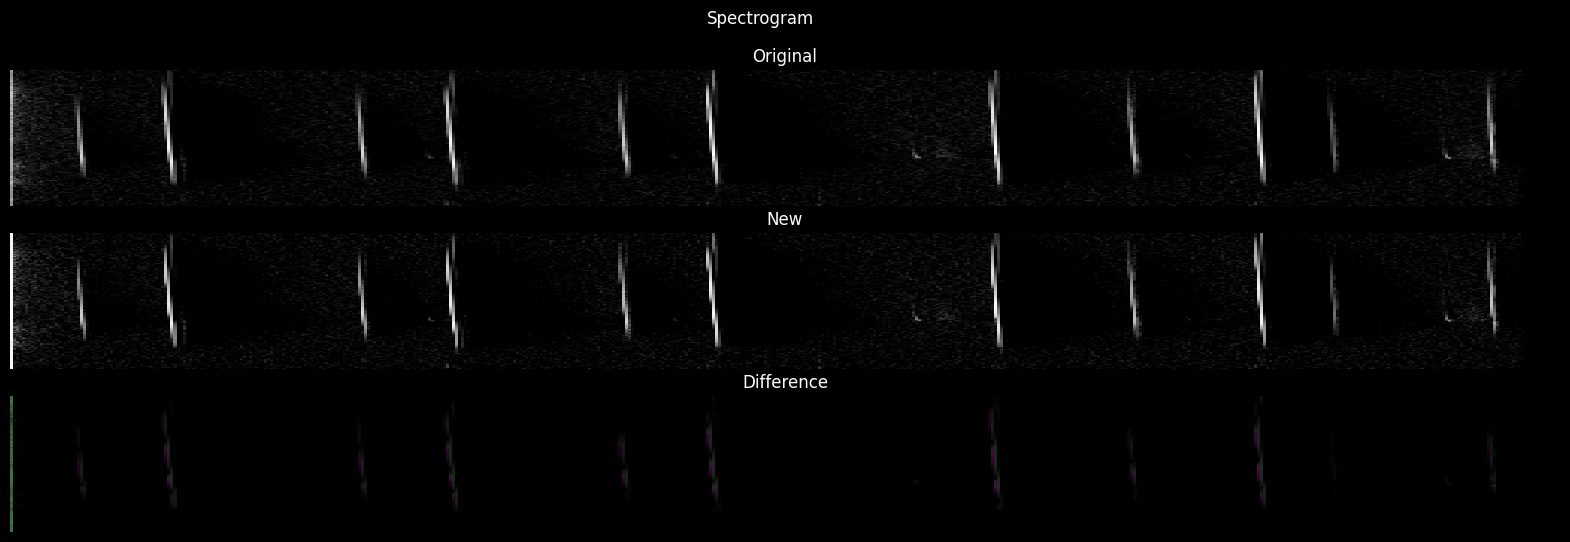

In [12]:
plot_versions(spec, new_spec, title="Spectrogram")

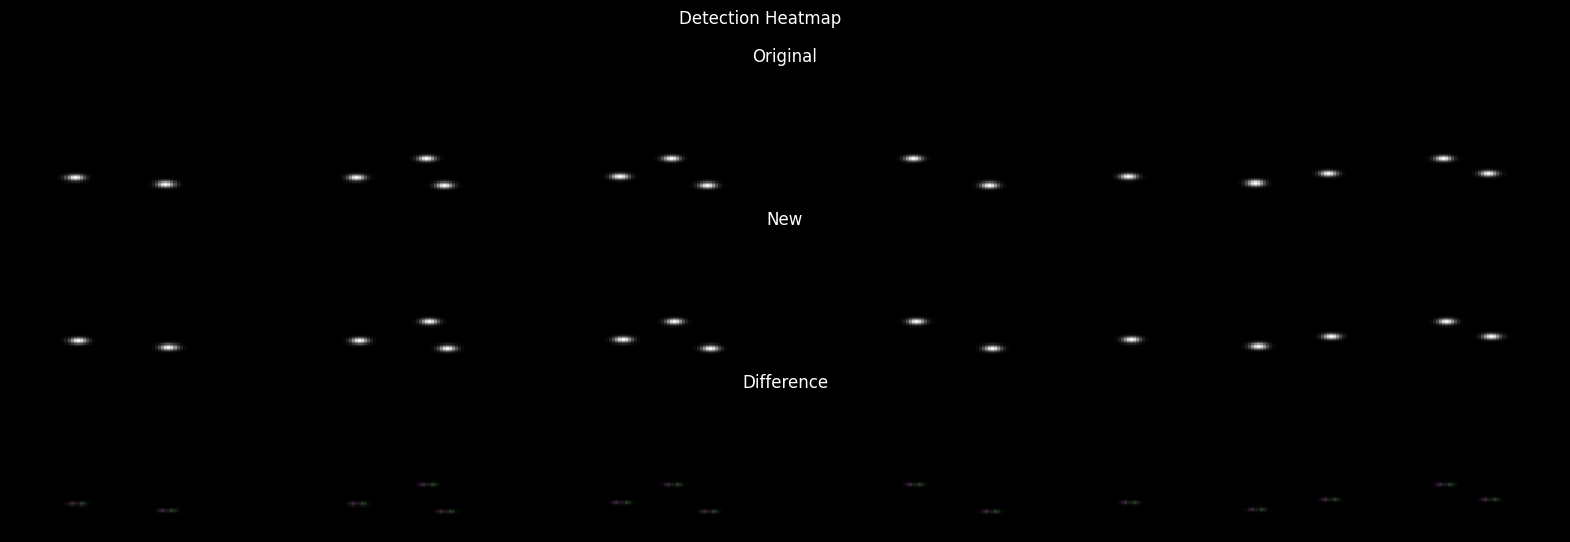

In [13]:
plot_versions(detection_mask, new_detection_mask, title="Detection Heatmap")

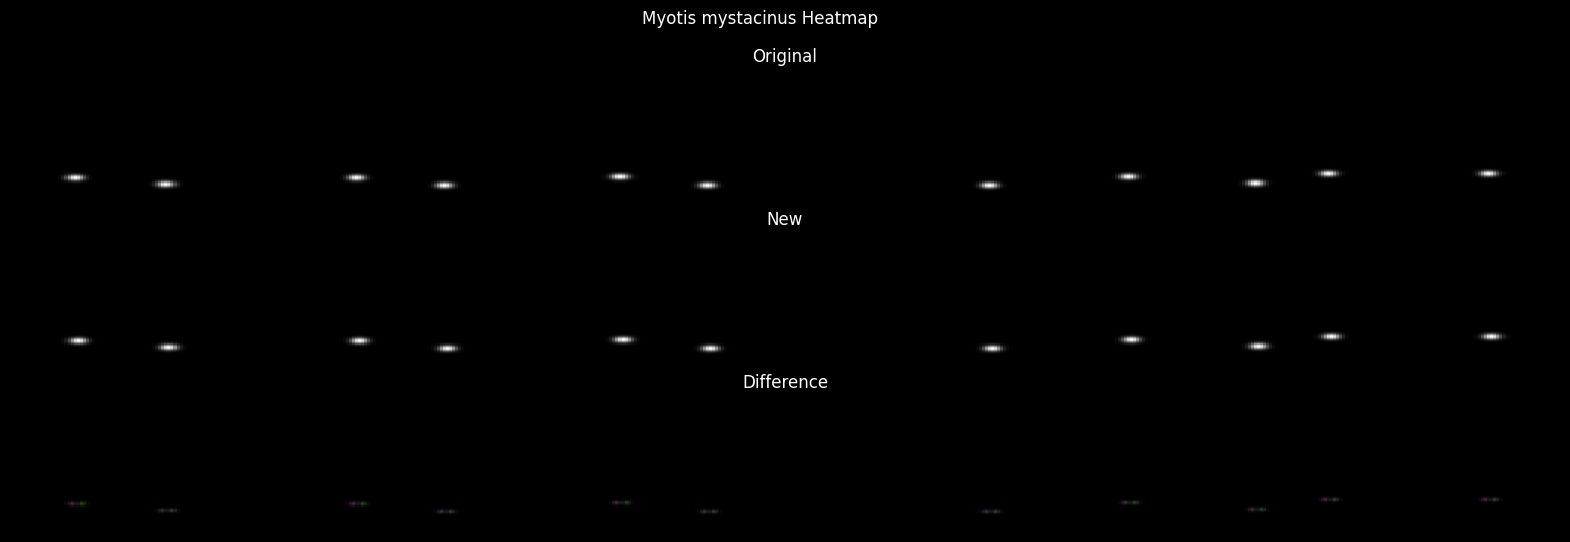

In [14]:
plot_versions(class_mask[6], new_class_mask[6], title=f"{new_dataset.category[6].values} Heatmap")

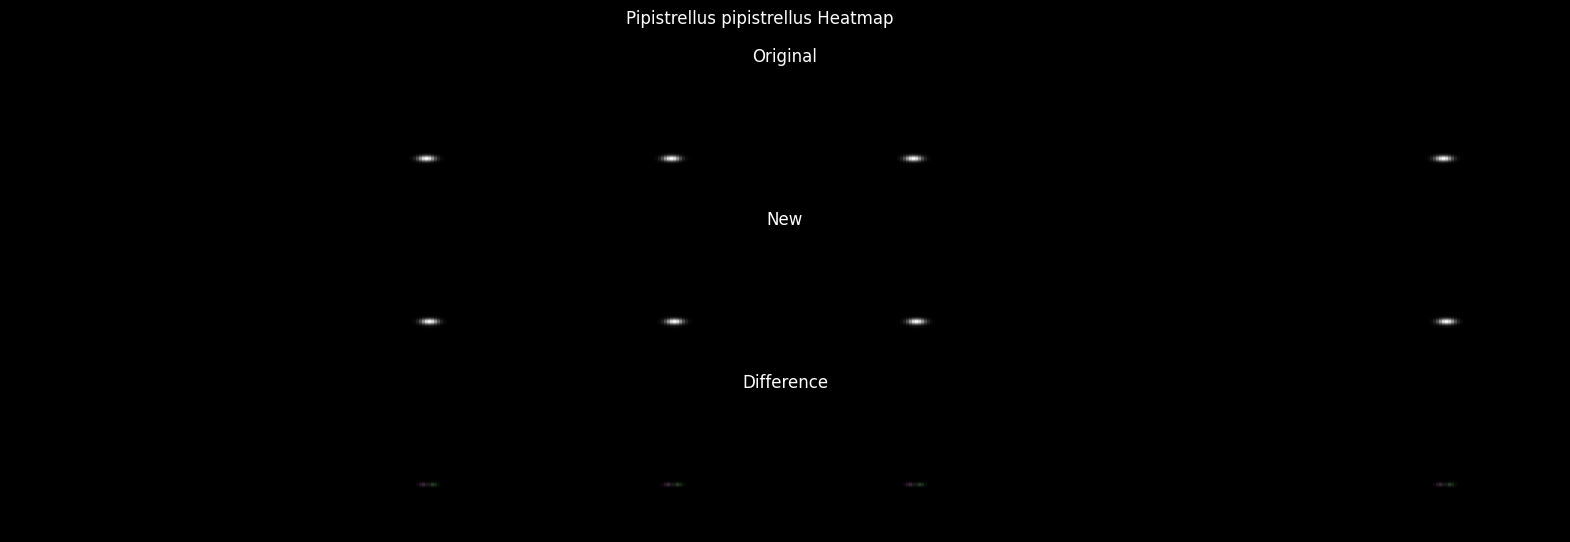

In [15]:
plot_versions(class_mask[11], new_class_mask[11], title=f"{new_dataset.category[11].values} Heatmap")

In [16]:
x_new, y_new = np.nonzero(new_size_mask.max(axis=0)) 
x_orig, y_orig = np.nonzero(np.flipud(size_mask.max(axis=0)))

assert (x_new == x_orig).all()

# NOTE: a difference of 1 pixel is due to discrepancies on how frequency bins are interpreted.
# shouldn't be an issue
assert (y_new == y_orig + 1).all()

width_new, height_new = values_new = new_size_mask[:, x_new, y_new]
width_orig, height_orig = values_orig = np.flip(size_mask,axis=1)[:, x_orig, y_orig]

assert (np.floor(width_new) == width_orig).all()
assert (np.ceil(height_new) == height_orig).all()

In [17]:
old_parameters

{'data_dir': '/data1/bat_data/data/',
 'ann_dir': '/data1/bat_data/annotations/anns_same/',
 'train_split': 'same',
 'standardize_classs_names_ip': 'Rhinolophus ferrumequinum;Rhinolophus hipposideros',
 'model_name': 'Net2DFast',
 'num_filters': 128,
 'experiment': '../../experiments/2021_12_13__20_20_37/',
 'model_file_name': '../../experiments/2021_12_13__20_20_37/2021_12_13__20_20_37.pth.tar',
 'op_im_dir': '../../experiments/2021_12_13__20_20_37/op_ims/',
 'op_im_dir_test': '../../experiments/2021_12_13__20_20_37/op_ims_test/',
 'notes': '',
 'target_samp_rate': 256000,
 'fft_win_length': 0.002,
 'fft_overlap': 0.75,
 'max_freq': 120000,
 'min_freq': 10000,
 'resize_factor': 0.5,
 'spec_height': 256,
 'spec_train_width': 512,
 'spec_divide_factor': 32,
 'denoise_spec_avg': True,
 'scale_raw_audio': False,
 'max_scale_spec': False,
 'spec_scale': 'pcen',
 'detection_overlap': 0.01,
 'ignore_start_end': 0.01,
 'detection_threshold': 0.01,
 'nms_kernel_size': 9,
 'nms_top_k_per_sec': 